<a href="https://colab.research.google.com/github/pearlfranz20/Franz_BIX_F22/blob/main/final_project_legit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Hypotheses

## Introduction
In this notebook we study the application of Kullback-Leibler Divergence and Jensen-Shannon Divergence for determining when a new hypothesis should be selected. 

We look at what happens when Kullback-Leibler Divergence (KL Divergence) or Jensen-Shannon Divergence (JS Divergence) are used to estimate when a hypothesis is no longer viable, and possible options for new hypothesis selection when this is the case.

For two distributions $P$ and $Q$, where $P$ is the ground truth distribution we are trying to approximate with a hypothesis $Q$, divergence tells us how different these two distributions are.

Kullback-Leibler Divergence (for a discrete distribution) is defined as:
$D_{KL}(P||Q) = \Sigma_{x\in X}p_i(x)* log_2(\frac{p_i(x)}{q_i(x)})$

which can also be interpreted as the average number of additional bits needed to encode information from $P$ when using hypothesis $Q$, the average information loss of using $Q$ to model $P$, or the expected surprise of gaining new information when using $Q$ to model $P$.

Jensen-Shannon Divergence is defined as:
$D_{JS}(P||Q) = H(M) - \frac{1}{2}(H(P) + H(Q))$

where $M$ is a mixed distribution of $P$ and $Q$, and $H$ denotes the Shannon entropy of a function.

For the purposes of this project, we will be calculating Jensen-Shannon Divergence as: 
$D_{JS}(P||Q) = D_{KL}(P_{norm}, M) + D_{KL}(Q_{norm}, M)$

where $P_{norm}$ and $Q_{norm}$ are $P$ and $Q$ normalized, respectively.

Both of these divergences are helpful in understanding the difference between two distributions, but with a few differences. For one, JS Divergence is finite (bounded by 0 and 1) and symmetric, whereas KL Divergence can be infinite (but $\geq0)$ and is asymmetric.

In order to understand how inefficient a hypothesis is, we will also be using Shannon Entropy, which is defined as:
$H(X) = -\Sigma_{x\in X}p(x)log_{2}(p(x)) = \Sigma_{x\in X}p(x)log_2(\frac{1}{p(x)})$

Shannon Entropy gives the average surprise, or amount of information in bits, of an event, considering all of its possible outcomes.

## Environment
In this environment, we will use Bernoulli variables to model all hypotheses and ground-truths, where our first value indicates a success probability, and our second value indicates a failure probability.

## Goals
The specific questions we wish to answer are how can KL Divergence and JS Divergence be applied to hypothesis selection and formation, for Bernoulli distributions. In addition, a minor goal is to also understand the relationship between KL and JS Divergence, and how these divergences relate to Shannon Entropy.

## Sections
There are 2 experiments/sections. (There is no min/max number. Break the project down as makes sense to you).

- _Section 1_ is where divergence and entropy are introduced
- _Section 2_ is where divergence is used to form a new hypothesis

## Metric
Our metrics of interest are simply KL Divergence and JS Divergence.

## The TED talk moment
The big question for this project is: 
**_How is it possible to know when a hypothesis is no longer helpful, and how can this information help someone form a new hypothesis when necessary?_**

A hypothesis $Q$ is only useful when it can reasonably approximate a ground-truth $P$, and knowing at what point a hypothesis is no longer useful or knowing how to shift a hypothesis to a more useful one preserves efficiency.

At the same time, we can also compare the performance of KL and JS Divergence values, and figure out which metric is more useful for determining when a hypothesis is no longer useful or optimizing a hypothesis $Q$.

### Import modules
Import what _you_ need

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import math
import scipy

# import explorationlib
# etc

### Config notebook
Please include this.

In [2]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Shared code

For the kl_divergence calculations we will be using the scipy.special.rel_entr function, which matches the definition of KL Divergence introduced earlier.
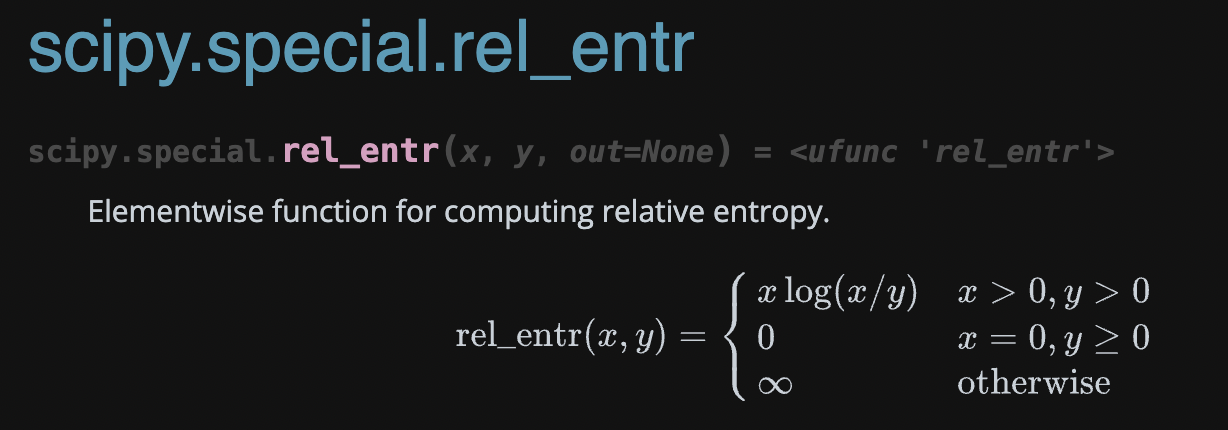

In [3]:
def js_divergence(distribution1, distribution2):
  normalized_first = distribution1 / np.linalg.norm(distribution1, ord=1)
  normalized_second = distribution2 / np.linalg.norm(distribution2, ord=1)
  mixed_distribution = (normalized_first + normalized_second)/2
  return scipy.special.rel_entr(normalized_first, mixed_distribution) + scipy.special.rel_entr(normalized_second, mixed_distribution)/2

In [4]:
def shannon_entropy(distribution):
  sum = 0
  for i in range(len(distribution)):
    sum += distribution[i] * math.log2(1/distribution[i])
    return sum

## Section 1 - Divergence
In this section we get a basic understanding of divergence, by demonstrating how KL and JS divergence values differ based on the difference between $P$ and $Q$ distributions.

First, let's generate a hypothesis $Q$ and a few ground truths $P_i$.

Our hypothesis $Q$ will be a Bernoulli variable with $p = .1$ and $q = (1-p) = .9$, while our different ground truths $P_i$ will have $p∈[.1, .9]$, incrementing by .1 for each $P_i$.

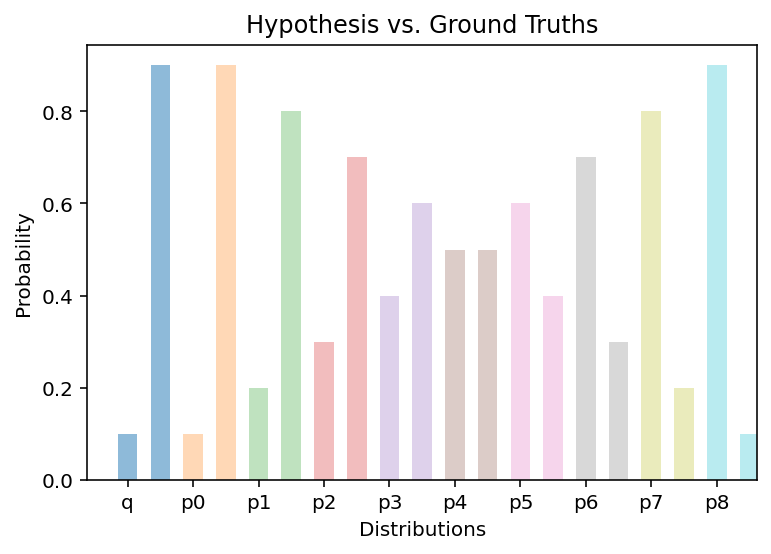

In [32]:
q = [.1, .9] # distribution we have
kl_values = [] # array for storing kl divergences for D_KL(P_i||Q)
js_values = [] # array for storing js divergences for D_JS(P_i||Q)
p_values = [] # array for storing the values for all P_i
plt.figure()
bars = plt.bar('q', q, alpha = .5, width = .3)
bars[1].set_x(bars[0].get_x() + .5)

for i in range(9):
  p = [(1 + i) * .1, 1 - (1 + i) * .1] # distribution we are trying to approximate
  p_values.append(p)
  kl_value = np.sum(scipy.special.rel_entr(p, q)) # calculating kl divergence
  kl_values.append(kl_value)
  js_value = np.sum(js_divergence(p, q)) # calculating js divergence
  js_values.append(js_value)
  bars = plt.bar(f'p{i}', p, alpha = .3, width = .3)
  bars[1].set_x(bars[0].get_x() + .5)

plt.title('Hypothesis vs. Ground Truths')
plt.ylabel('Probability')
plt.xlabel('Distributions')
plt.show()

Now, let's plot the KL and JS values for $D_{KL}(P_i||Q)$ and $D_{JS}(P_i||Q)$, for each $P_i$ in order to see how these values increase as the distributions become more and more different from one another.

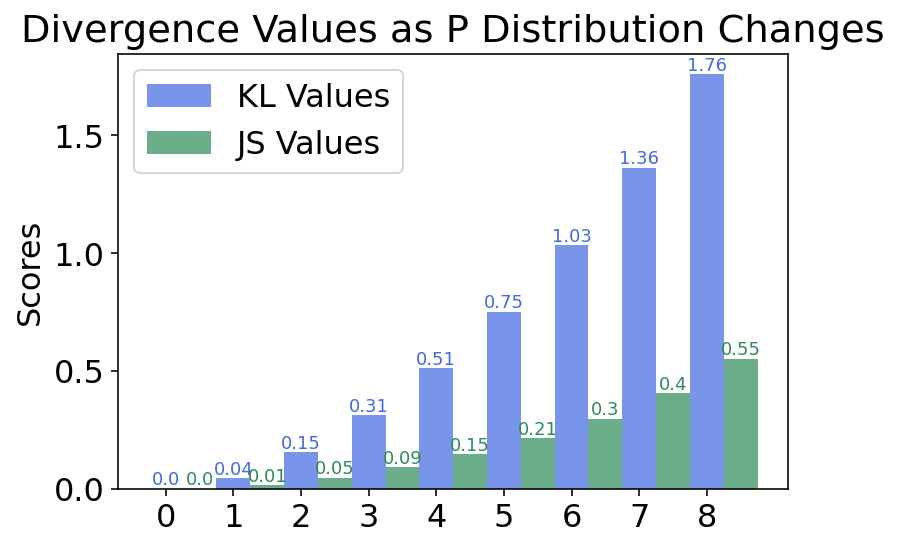

In [6]:
N = 9 # number of P_i

ind = np.arange(N)  # the x locations for the groups
width = 0.5     # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

# plotting the kl values
rects1 = ax.bar(ind, kl_values, width, color='royalblue', alpha = .7)
# adding kl values for each bar
for i in range(len(rects1)):
  plt.text(rects1[i].get_x() + rects1[i].get_width() / 2, rects1[i].get_height(), f'{round(kl_values[i], 2)}', ha='center', va='bottom', fontsize = '9', color = 'royalblue')

# plotting the js values
rects2 = ax.bar(ind+width, js_values, width, color='seagreen', alpha = .7)
# adding js values for each bar
for i in range(len(rects2)):
  plt.text(rects2[i].get_x() + rects2[i].get_width() / 2, rects2[i].get_height(), f'{round(js_values[i], 2)}', ha='center', va='bottom', fontsize = '9', color = 'seagreen')

ax.set_ylabel('Scores')
ax.set_title('Divergence Values as P Distribution Changes')
ax.set_xticks(ind)

ax.legend( (rects1[0], rects2[0]), ('KL Values', 'JS Values') )

plt.show()

Comparing the divergence values and the Shannon Entropy should give us an idea of when we need a new hypothesis. 

Since KL Divergence tells us the information loss of using hypothesis $Q$ to represent information from $P$, we should ideally switch our hypothesis once KL Divergence values are greater than or equal to half of the Shannon Entropy values. (This is to minimize inefficiency, and not make representing information from $P$ under $Q$ more inefficient than simply using $P$ itself.)

For our distribution, this seems to be about $D_{KL} ≈ .31$, which is around $P_3$.

Since KL Divergence values are not bounded like JS Divergence values are, KL Divergence values must be found empirically for our $P_i$ and $Q$. Thus it seems that for Bernoulli distributions, an appropriate JS Divergence value at which to switch hypotheses is about $D_{JS} = .09$.

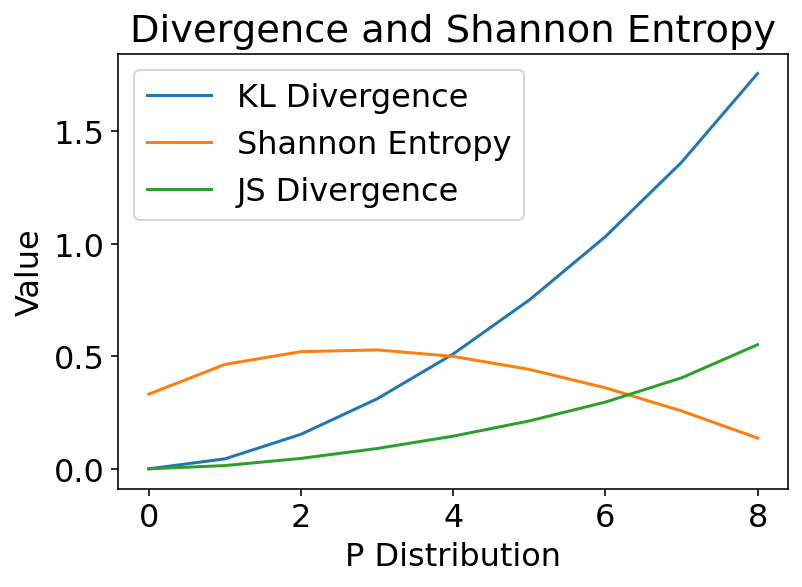

In [ ]:
p_types = range(9) # number of p_i
plt.plot(p_types, kl_values, label = "KL Divergence")

shannon_values = [] # array for Shannon Entropy values

# finding the Shannon Entropy for each P_i
for i in range(9):
  shannon_values.append(shannon_entropy(p_values[i]))

plt.plot(p_types, shannon_values, label = "Shannon Entropy")
plt.plot(p_types, js_values, label = "JS Divergence")
plt.xlabel("P Distribution")
plt.ylabel("Value")
plt.title("Divergence and Shannon Entropy")
plt.legend()

Below is a graph of the difference between the Shannon Entropy and the Divergence values for each $P_i$ when using hypothesis $Q$. The KL Divergence line thus corresponds to $H(P_i) - D_{KL}(P_i||Q)$, while the JS Divergence line corresponds to $H(P_i) - D_{JS}(P_i||Q)$. The KL line in particular helps demonstrate the sharp increase in inefficiency around the $P_4$, where the information loss of using $Q$ is about the same as the Shannon Entropy for $P_4$.

Thus, this helps confirm that switching our hypothesis $Q$ around $P_3$ would help preserve efficiency.

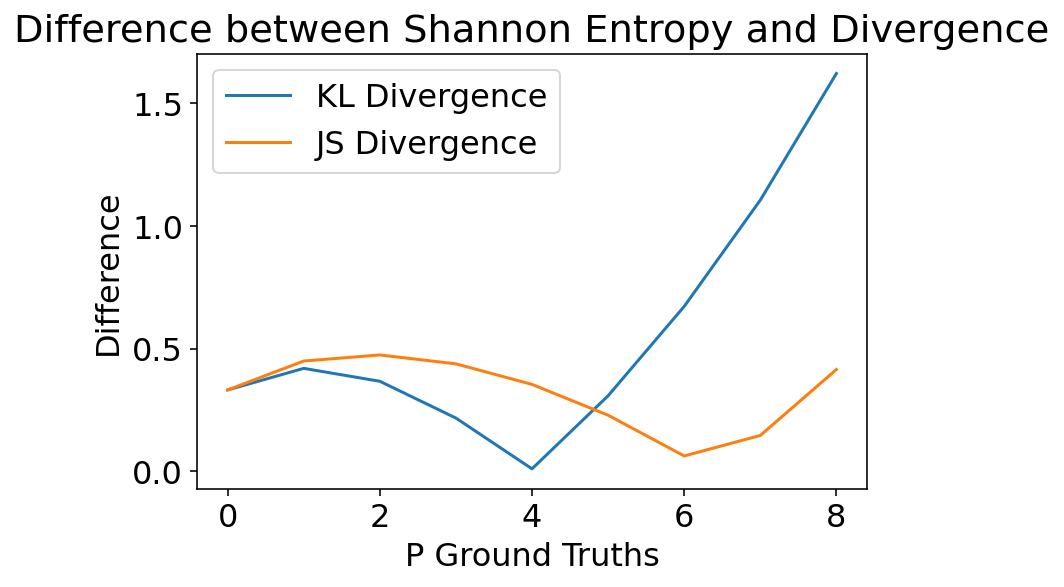

In [ ]:
differences_kl = [] # H(P_i) - D_KL(P_i||Q) for each P_i
differences_js = [] # H(P_i) - D_JS(P_i||Q) for each P_i

# calculating differences
for i in range(len(p_types)):
  difference = abs(shannon_values[i] - kl_values[i])
  differences_kl.append(difference)
  difference = abs(shannon_values[i] - js_values[i])
  differences_js.append(difference)

plt.plot(p_types, differences_kl, label = "KL Divergence")
plt.plot(p_types, differences_js, label = "JS Divergence")
plt.title("Difference between Shannon Entropy and Divergence")
plt.ylabel('Difference')
plt.xlabel('P Ground Truths')
plt.legend()
plt.show()

## Section 2 - Optimizing Distributions based on Divergence
In this section we use KL and JS divergence in order to select a new hypothesis, given our current hypothesis $Q$ and a ground-truth distribution $P$.

Below are two recursive functions that will use Divergence values to create a new optimized hypothesis, with one using KL Divergence and another using JS Divergence.

Each function works the same, in that it takes in a ground truth $P$, a hypothesis $Q$, a starting increment value, as well as a tolerance level. 

By changing the values of $Q$ by adding or subtracting the increment_value, and comparing the divergences values of the new $Q_{new}$ values with the original $Q$. If changing the values of $Q$ did not decrease the divergence value, we can halve the increment_value in order to continue searching for the optimal divergence value below tolerance level. 

By continually finding new hypotheses $Q$ with lower and lower divergence values, the function eventually can find a new hypothesis $Q$ with a divergence value below the tolerance level

In [8]:
# JS Divergence Optimization Function
def find_new_hypothesis_js(p, q, increment_value, tolerance):
  # find the current JS Divergence
  js_divergence_curr = sum(js_divergence(p, q))
  # return Q when divergence value is below tolerance
  if(js_divergence_curr < tolerance):
    return q
  q_upper = [] # increasing p (probability success) for Q
  q_lower = [] # decreasing p (probability success) for Q
  q_upper = [q[0] + increment_value, q[1] - increment_value]
  q_lower = [q[0] - increment_value, q[1] + increment_value]

  # find divergence values of modified Q_new hypotheses
  js_divergence_upper = sum(js_divergence(p, q_upper))
  js_divergence_lower = sum(js_divergence(p, q_lower))
  # if we found a better Q_new, continue optimizing with Q_new
  if(js_divergence_upper < js_divergence_curr):
    return find_new_hypothesis_js(p, q_upper, increment_value, tolerance)
  elif(js_divergence_lower < js_divergence_curr):
    return find_new_hypothesis_js(p, q_lower, increment_value, tolerance)
  else: # case where (js_divergence_curr < js_divergence_lower && js_divergence_curr < js_divergence_upper)
  # if we didn't find a better Q_new, decrease increment_value and continue
    return find_new_hypothesis_js(p, q, increment_value * .5, tolerance)

# KL Divergence Optimization Function
def find_new_hypothesis_kl(p, q, increment_value, tolerance):
  # find the current KL Divergence
  kl_divergence_curr = sum(scipy.special.rel_entr(p, q))
  # return Q when divergence value is below tolerance
  if(kl_divergence_curr < tolerance):
    return q
  q_upper = [] # increasing p (probability success, first value) for Q
  q_lower = [] # decreasing p (probability success, first value) for Q
  q_upper = [q[0] + increment_value, q[1] - increment_value]
  q_lower = [q[0] - increment_value, q[1] + increment_value]
  kl_divergence_upper = sum(scipy.special.rel_entr(p, q_upper))
  kl_divergence_lower = sum(scipy.special.rel_entr(p, q_lower))
  # if we found a better Q_new, continue optimizing with Q_new
  if(kl_divergence_upper < kl_divergence_curr):
    return find_new_hypothesis_kl(p, q_upper, increment_value, tolerance)
  elif(kl_divergence_lower < kl_divergence_curr):
    return find_new_hypothesis_kl(p, q_lower, increment_value, tolerance)
  else: # case where (kl_divergence_curr < kl_divergence_lower && kl_divergence_curr < kl_divergence_upper)
  # if we didn't find a better Q_new, decrease increment_value and continue
    return find_new_hypothesis_kl(p, q, increment_value * .5, tolerance)

Below are the plots comparing the performance of the KL and JS Divergence optimization functions.

In the following code, we will use tolerance values of $.1, .01, .001, .0001$ in order to compare the performance of using KL and JS values to optimize a hypothesis. 

$p$ refers to a ground truth of $[.5, .5]$, $q_{start}$ denotes a starting hypothesis of $[.1, .9]$, and $q_i$ denotes an optimized hypothesis with a tolerance value $i$.

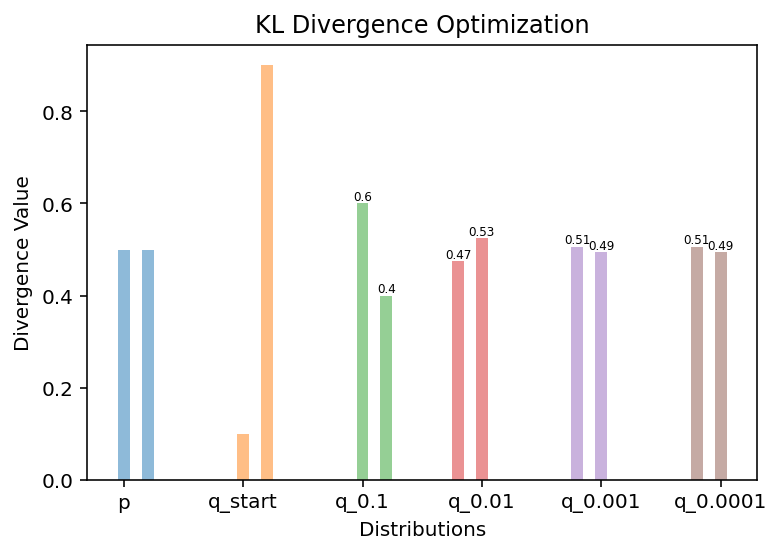

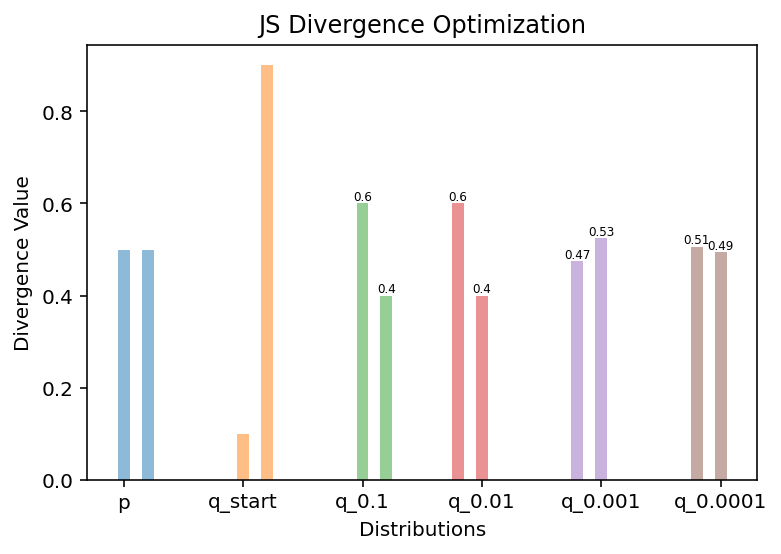

In [31]:
tolerance_values = [.1, .01, .001, .0001] # tolerances we will be testing with
kl_optimized_values = [] # array for kl optimization results
js_optimized_values = [] # array for js optimization results

# find optimized Q for each tolerance value
for tolerance in tolerance_values:
  kl_optimized_values.append(find_new_hypothesis_kl(p, q1, increment_value, tolerance))
  js_optimized_values.append(find_new_hypothesis_js(p, q1, increment_value, tolerance))

## plot KL optimization results ##
plt.figure()
plt.title("KL Divergence Optimization")
plt.xlabel("Distributions")
plt.ylabel("Divergence Value")
plt.rc('font', size=10)  

# plot ground truth P and starting hypothesis Q
bars = plt.bar('p', p, alpha = .5, width = .1)
bars[1].set_x(bars[0].get_x() + .2)
bars = plt.bar('q_start', q1, alpha = .5, width = .1)
bars[1].set_x(bars[0].get_x() + .2)

# plot kl optimized results
for i in range(len(kl_optimized_values)):
  value = 10**(-(i + 1))
  bars = plt.bar(f'q_{value}', kl_optimized_values[i], alpha = .5, width = .1)
  if i > 0:
    bars[0].set_x(bars[1].get_x() - .2)
  else:
    bars[1].set_x(bars[0].get_x() + .2)
  plt.text(bars[0].get_x() + bars[0].get_width() / 2, bars[0].get_height(), f'{round(kl_optimized_values[i][0], 2)}', ha='center', va='bottom', fontsize = '6')
  plt.text(bars[1].get_x() + bars[1].get_width() / 2, bars[1].get_height(), f'{round(kl_optimized_values[i][1], 2)}', ha='center', va='bottom', fontsize = '6')


## plot JS optimization results ##
plt.figure()
plt.title("JS Divergence Optimization")
plt.xlabel("Distributions")
plt.ylabel("Divergence Value")
plt.rc('font', size=10)  

# plot ground truth P and starting hypothesis Q
bars = plt.bar('p', p, alpha = .5, width = .1)
bars[1].set_x(bars[0].get_x() + .2)
bars = plt.bar('q_start', q1, alpha = .5, width = .1)
bars[1].set_x(bars[0].get_x() + .2)

# plot js optimized results
for i in range(len(js_optimized_values)):
  value = 10**(-(i + 1))
  bars = plt.bar(f'q_{value}', js_optimized_values[i], alpha = .5, width = .1)
  if i > 0:
    bars[0].set_x(bars[1].get_x() - .2)
  else:
    bars[1].set_x(bars[0].get_x() + .2)
  plt.text(bars[0].get_x() + bars[0].get_width() / 2, bars[0].get_height(), f'{round(js_optimized_values[i][0], 2)}', ha='center', va='bottom', fontsize = '6')
  plt.text(bars[1].get_x() + bars[1].get_width() / 2, bars[1].get_height(), f'{round(js_optimized_values[i][1], 2)}', ha='center', va='bottom', fontsize = '6')

It appears that the KL Divergence optimized $Q$ hypotheses are closer to the intended hypothesis for tolerance values of $.01$ and $.001$. This is likely due to the fact that JS Divergence values are bounded between $[0, 1]$, meaning that a lower tolerance value is likely needed to reach the same level of similarity as compared to the KL Divergence optimization function. Indeed, the tolerance value of $.0001$ gives roughly the same KL and JS Divergence optimization, indicating that at tolerance values $\gtrapprox .1$ or $\lessapprox .0001$ the divergence optimization functions have more or less the same performance.

## Conclusions
This project demonstrated how KL Divergence and JS Divergence values can be used to quantify how different two distributions are, which in turn can explain when a hypothesis is no longer viable to use.

For Bernoulli distributions, it appears that a KL Divergence value of $\approx.31$ or a JS Divergence value of $≈.09$ is the point where encoding information from a ground-truth $P$ using hypothesis $Q$ is more inefficient than using $P$ itself. More generally speaking, we can use KL Divergence to tell when a hypothesis $Q$ is more than half the Shannon Entropy value for a ground-truth $P$, implying that we should change our hypothesis $Q$.

Moreover, we discovered how to use divergence values to optimize a hypothesis. When using KL and JS Divergences to optimize a hypothesis, we found that the behavior of KL and JS Divergence optimization is similar for tolerance values above or about $.1$ and less than or about $.0001$. Yet for tolerance values $\in [.01, .001]$, KL Divergence optimization appears to perform better than JS Divergence values.